In [1]:
# # If needed, create a virtual environment by uncommenting the line below:
# !python -m venv .venv

# # Activate the virtual environment by running the appropriate command for your OS:
# # On Windows:
# # !.\.venv\Scripts\activate

# # On macOS/Linux:
# !source .agentic_ai_venv/bin/activate 

# # Install the required packages by uncommenting the line below:
# %pip install -r ./requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn 
from IPython.display import display
from pathlib import Path
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from typing import Tuple, cast
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier


In [3]:
df = pd.read_csv("pet_adoption_data.csv")

In [4]:
df

,PetID,PetType,Breed,AgeMonths,Color,Size,WeightKg,Vaccinated,HealthCondition,TimeInShelterDays,AdoptionFee,PreviousOwner,AdoptionLikelihood
0,500,Bird,Parakeet,131,Orange,Large,5.039768,1,0,27,140,0,0
1,501,Rabbit,Rabbit,73,White,Large,16.086727,0,0,8,235,0,0
2,502,Dog,Golden Retriever,136,Orange,Medium,2.076286,0,0,85,385,0,0
3,503,Bird,Parakeet,97,White,Small,3.339423,0,0,61,217,1,0
4,504,Rabbit,Rabbit,123,Gray,Large,20.498100,0,0,28,14,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,2502,Dog,Poodle,72,Orange,Small,27.039045,1,0,66,26,1,1
2003,2503,Rabbit,Rabbit,124,Brown,Small,4.726954,1,1,59,150,0,0
2004,2504,Rabbit,Rabbit,113,Orange,Small,1.758592,1,0,68,302,0,0
2005,2505,Dog,Labrador,12,Gray,Large,20.961592,1,0,59,478,0,0


In [5]:
df['AdoptionLikelihood'].value_counts()

AdoptionLikelihood
0    1348
1     659
Name: count, dtype: int64

<Figure size 1100x600 with 0 Axes>

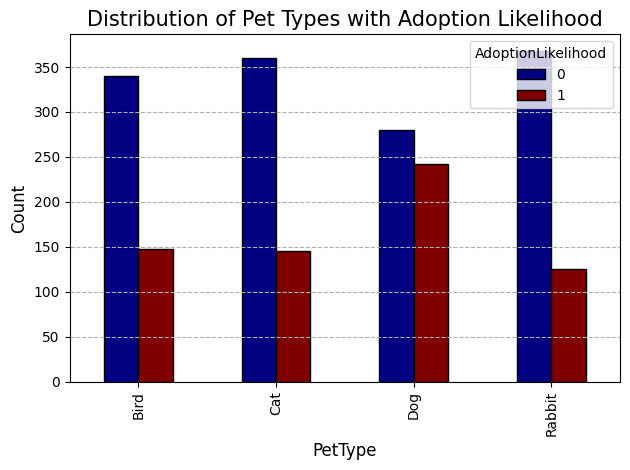

In [6]:
df['PetType'].value_counts()

# Count how many pets per (PetType, AdoptionLikelihood)
counts = df.groupby(['PetType', 'AdoptionLikelihood']).size().unstack(fill_value=0)
plt.figure(figsize=(11,6))
counts.plot(kind='bar', color=plt.cm.jet(np.linspace(0, 1, counts.shape[1])), edgecolor='black')
plt.title('Distribution of Pet Types with Adoption Likelihood', fontsize=15)
plt.xlabel('PetType', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--')
plt.legend(title='AdoptionLikelihood')
plt.tight_layout()
plt.show()

<Figure size 1100x600 with 0 Axes>

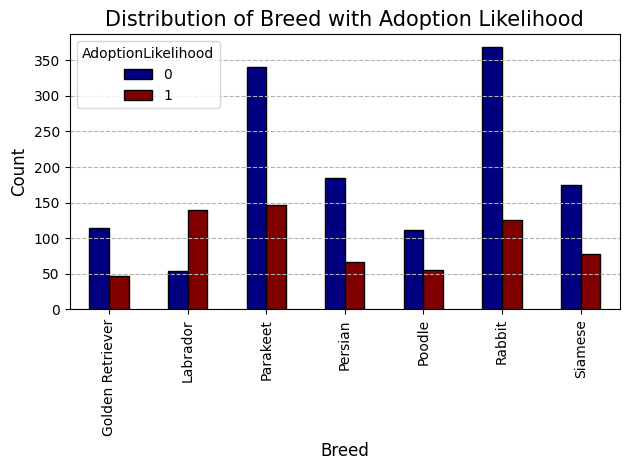

In [7]:
counts = df.groupby(['Breed', 'AdoptionLikelihood']).size().unstack(fill_value=0)
plt.figure(figsize=(11,6))
counts.plot(kind='bar', color=plt.cm.jet(np.linspace(0, 1, counts.shape[1])), edgecolor='black')
plt.title('Distribution of Breed with Adoption Likelihood', fontsize=15)
plt.xlabel('Breed', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--')
plt.legend(title='AdoptionLikelihood')
plt.tight_layout()
plt.show()

/var/folders/sy/yzs3s3rj1sn1mtlmxbmv67740000gn/T/ipykernel_47679/1762506190.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(['AgeGroup', 'AdoptionLikelihood']).size().unstack(fill_value=0)


<Figure size 1200x600 with 0 Axes>

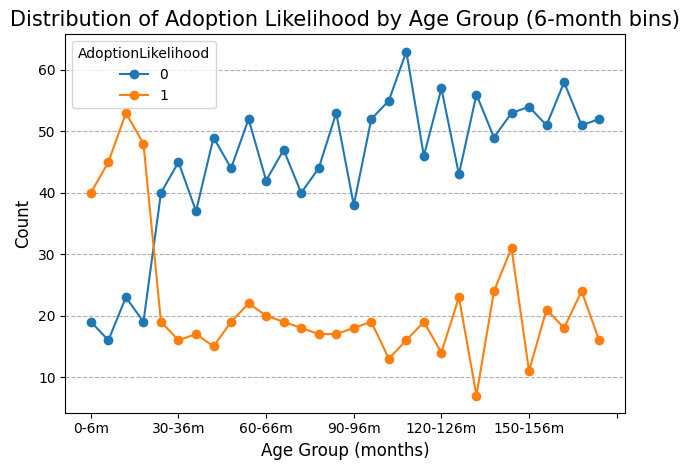

In [8]:
# Create bins of 6 months (same as before)
df['AgeGroup'] = pd.cut(
    df['AgeMonths'],
    bins=np.arange(0, df['AgeMonths'].max() + 6, 6), # Start at 0, end at max age + 6, step by 6 → creates intervals of 6 months
    right=False,
    labels=[f'{i}-{i+6}m' for i in range(0, df['AgeMonths'].max(), 6)] # Creates strings like '0-6m', '6-12m', '12-18m', etc.
)

# Count how many pets per (AgeGroup, AdoptionLikelihood)
counts = df.groupby(['AgeGroup', 'AdoptionLikelihood']).size().unstack(fill_value=0)

# Plot as line graph
plt.figure(figsize=(12,6))
counts.plot(kind='line', marker='o')  # marker='o' adds points to the line

plt.title('Distribution of Adoption Likelihood by Age Group (6-month bins)', fontsize=15)
plt.xlabel('Age Group (months)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--')
plt.legend(title='AdoptionLikelihood')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'The Chance of a Pet being Adopted depending on its Size')

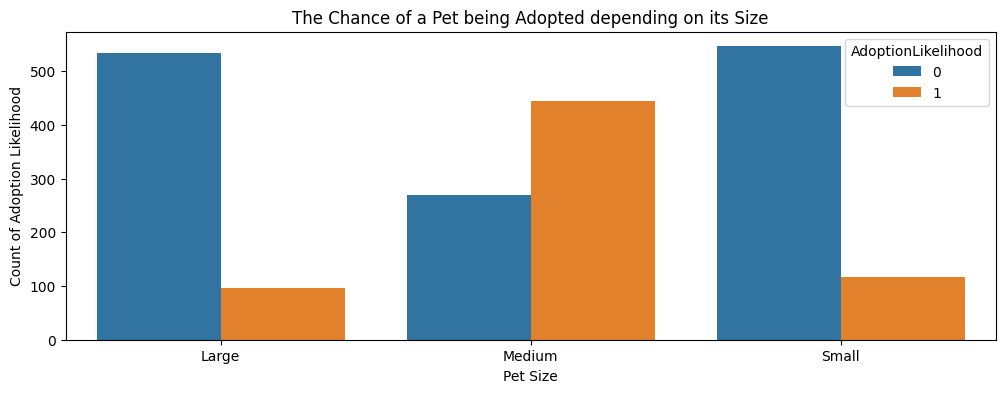

In [9]:
fig, ax =plt.subplots(figsize = [12, 4])
seaborn.countplot(x = df['Size'], hue = df['AdoptionLikelihood'])

ax.set_xlabel('Pet Size')
ax.set_ylabel('Count of Adoption Likelihood')
plt.title ('The Chance of a Pet being Adopted depending on its Size')

Text(0.5, 1.0, 'The Chance of a Pet being Adopted depending on its Color')

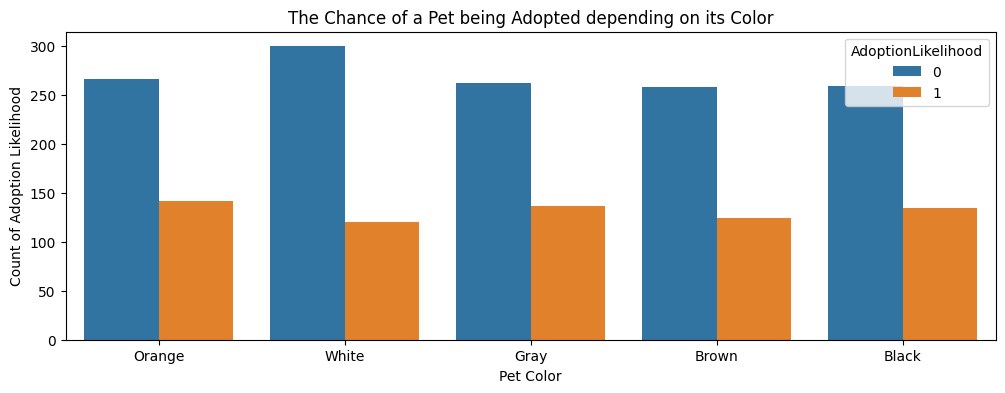

In [10]:
fig, ax =plt.subplots(figsize = [12, 4])
seaborn.countplot(x = df['Color'], hue = df['AdoptionLikelihood'])

ax.set_xlabel('Pet Color')
ax.set_ylabel('Count of Adoption Likelihood')
plt.title ('The Chance of a Pet being Adopted depending on its Color')

In [11]:
df_adoption = df[df['AdoptionLikelihood'] ==1]
df_adoption

,PetID,PetType,Breed,AgeMonths,Color,Size,WeightKg,Vaccinated,HealthCondition,TimeInShelterDays,AdoptionFee,PreviousOwner,AdoptionLikelihood,AgeGroup
7,507,Cat,Siamese,13,Orange,Large,7.252683,1,0,3,137,0,1,12-18m
11,511,Rabbit,Rabbit,5,White,Small,29.078056,1,0,60,462,0,1,0-6m
14,514,Cat,Persian,160,Brown,Medium,6.303899,1,0,11,404,0,1,156-162m
17,517,Cat,Persian,50,White,Medium,28.982929,1,0,13,109,0,1,48-54m
22,522,Dog,Labrador,3,Gray,Large,15.576273,1,0,50,369,1,1,0-6m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,2493,Bird,Parakeet,115,Orange,Small,24.967156,1,0,37,358,1,1,114-120m
1995,2495,Rabbit,Rabbit,72,Black,Medium,26.517957,0,0,69,429,1,1,72-78m
1999,2499,Cat,Persian,16,Gray,Medium,18.007326,0,0,13,404,0,1,12-18m
2001,2501,Bird,Parakeet,179,Brown,Small,29.475254,1,0,69,197,0,1,174-180m


Text(0.5, 1.0, 'The Number of pets adopted depending on its size')

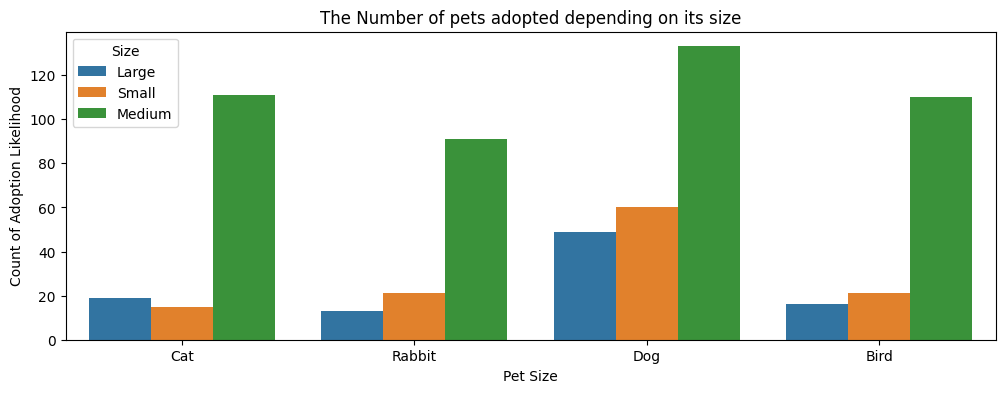

In [12]:
fig, ax =plt.subplots(figsize = [12, 4])
seaborn.countplot(x = df_adoption['PetType'], hue = df_adoption['Size'])

ax.set_xlabel('Pet Size')
ax.set_ylabel('Count of Adoption Likelihood')
plt.title ('The Number of pets adopted depending on its size')

Text(0.5, 1.0, 'The Number of pets adopted depending on its color')

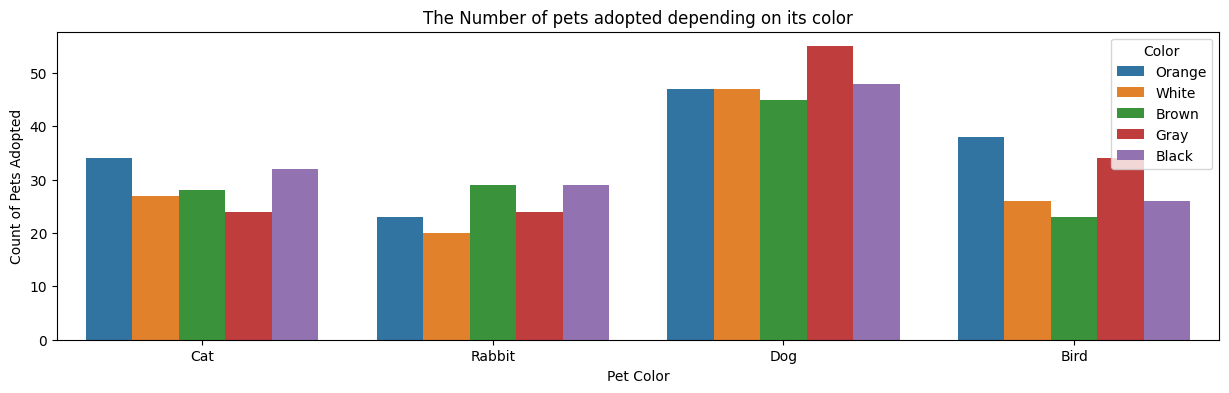

In [13]:
fig, ax =plt.subplots(figsize = [15, 4])
seaborn.countplot(x = df_adoption['PetType'], hue = df_adoption['Color'])

ax.set_xlabel('Pet Color')
ax.set_ylabel('Count of Pets Adopted')
plt.title ('The Number of pets adopted depending on its color')

In [14]:
df_plot = df[['WeightKg', 'AdoptionLikelihood']].copy()

# Create 1-kg bins from 0 to 30
bins = np.arange(0, 31, 1)  
df_plot['WeightBin'] = pd.cut(df_plot['WeightKg'], bins=bins, right=False)

# Count number of pets per bin and adoption likelihood
weight_counts = df_plot.groupby(['WeightBin', 'AdoptionLikelihood']).size().reset_index(name='Count')
weight_counts['WeightStart'] = weight_counts['WeightBin'].apply(lambda x: x.left)

/var/folders/sy/yzs3s3rj1sn1mtlmxbmv67740000gn/T/ipykernel_47679/3047752311.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weight_counts = df_plot.groupby(['WeightBin', 'AdoptionLikelihood']).size().reset_index(name='Count')


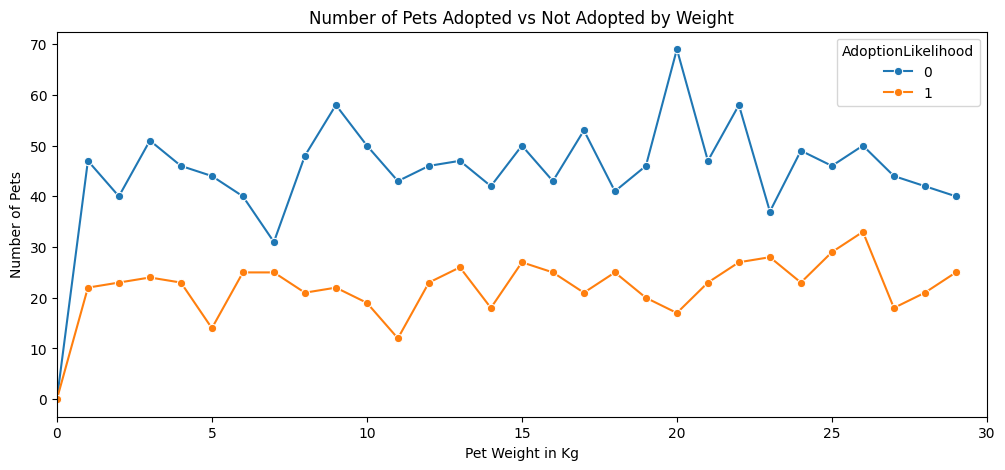

In [15]:
fig, ax = plt.subplots(figsize=[12,5])
seaborn.lineplot(data=weight_counts, x='WeightStart', y='Count', hue='AdoptionLikelihood', marker='o', ax=ax )

ax.set_xlabel('Pet Weight in Kg')
ax.set_ylabel('Number of Pets')
plt.title('Number of Pets Adopted vs Not Adopted by Weight')
plt.xlim(0, 30)
plt.show()

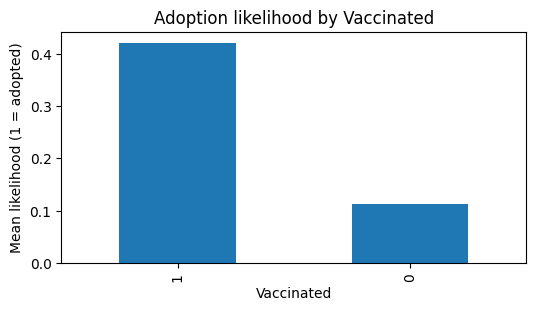

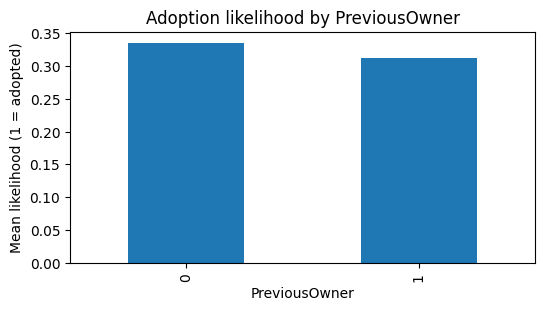

In [16]:
for col in ['Vaccinated', 'PreviousOwner']:
    adoption_rate = df.groupby(col)['AdoptionLikelihood'].mean().sort_values(ascending=False)
    adoption_rate.plot(kind='bar', figsize=(6,3))
    plt.title(f"Adoption likelihood by {col}")
    plt.ylabel("Mean likelihood (1 = adopted)")
    plt.show()

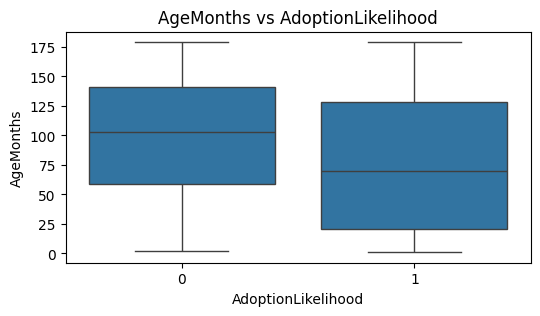

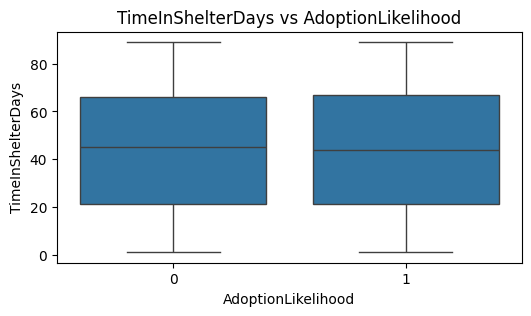

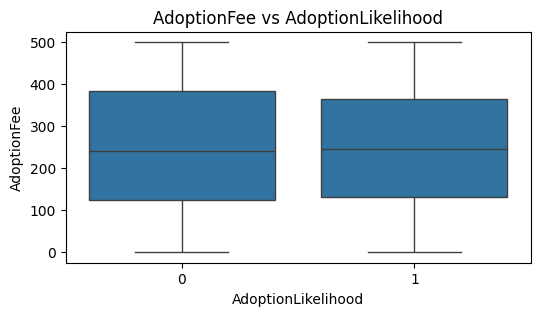

In [17]:
num_cols = ['AgeMonths', 'TimeInShelterDays', 'AdoptionFee']
for col in num_cols:
    plt.figure(figsize=(6,3))
    seaborn.boxplot(x='AdoptionLikelihood', y=col, data=df)
    plt.title(f"{col} vs AdoptionLikelihood")
    plt.show()

In [18]:
df = df.drop (columns="AgeGroup")
df

,PetID,PetType,Breed,AgeMonths,Color,Size,WeightKg,Vaccinated,HealthCondition,TimeInShelterDays,AdoptionFee,PreviousOwner,AdoptionLikelihood
0,500,Bird,Parakeet,131,Orange,Large,5.039768,1,0,27,140,0,0
1,501,Rabbit,Rabbit,73,White,Large,16.086727,0,0,8,235,0,0
2,502,Dog,Golden Retriever,136,Orange,Medium,2.076286,0,0,85,385,0,0
3,503,Bird,Parakeet,97,White,Small,3.339423,0,0,61,217,1,0
4,504,Rabbit,Rabbit,123,Gray,Large,20.498100,0,0,28,14,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,2502,Dog,Poodle,72,Orange,Small,27.039045,1,0,66,26,1,1
2003,2503,Rabbit,Rabbit,124,Brown,Small,4.726954,1,1,59,150,0,0
2004,2504,Rabbit,Rabbit,113,Orange,Small,1.758592,1,0,68,302,0,0
2005,2505,Dog,Labrador,12,Gray,Large,20.961592,1,0,59,478,0,0


In [19]:
df.isnull().sum()

PetID                 0
PetType               0
Breed                 0
AgeMonths             0
Color                 0
Size                  0
WeightKg              0
Vaccinated            0
HealthCondition       0
TimeInShelterDays     0
AdoptionFee           0
PreviousOwner         0
AdoptionLikelihood    0
dtype: int64